In [1]:
# config
import torch
import torch.nn as nn

# hyperparameters
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cpu') if gpu_id < 0 else torch.device('cuda:%d' % gpu_id)
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
hidden_size = 512
output_size = 1
num_head = 16
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
grad_acc = True
grad_acc_iter = 8

batch_size = 64
n_epochs = 1000

In [2]:
# dataloader
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from utils import pid_diff_collate_fn
from torch.utils.data import DataLoader, random_split

dataset = ASSIST2009_PID_DIFF(max_seq_len)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

train_size = int( len(dataset) * train_ratio * (1 - valid_ratio))
valid_size = int( len(dataset) * train_ratio * valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [ train_size, valid_size, test_size ]
    )

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

In [3]:
# model
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F

# SeparableConv1D
class SeparableConv1D(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size):
        super().__init__()

        # input_filters = 512 <- hidden_size
        # output_filters = 256 <- all_attn_head_size

        self.depthwise = nn.Conv1d(input_filters, input_filters, kernel_size=kernel_size, groups=input_filters, padding=kernel_size //2, bias = False)
        self.pointwise = nn.Conv1d(input_filters, output_filters, kernel_size=1, bias=False)
        self.bias = nn.Parameter(torch.zeros(output_filters, 1))

        self.depthwise.weight.data.normal_(mean=0.0, std=0.02)
        self.pointwise.weight.data.normal_(mean=0.0, std=0.02)

    def forward(self, hidden_states):
        # |hidden_states| = (bs, hs, n)

        x = self.depthwise(hidden_states)
        # |x| = (bs, hs, n)

        x = self.pointwise(x)
        # |x| = (bs, hs/2(all_attn_h_size), n)

        x += self.bias
        # |x| = (bs, hs/2(all_attn_h_size), n)
        return x

# Thank for the Huggingface and Author of AKT
# Combined the Monotonic Attention and Span Dynamic Convolutional Attention
class ConvolutionalMultiheadAttention(nn.Module):
    # hidden % n_splits == 0
    def __init__(self, hidden_size, n_splits, dropout_p, head_ratio=2, conv_kernel_size=9):
        super().__init__()
        # default: n_splits = 16, head_ratio = 2
        
        new_num_attention_heads = n_splits // head_ratio
        self.num_attention_heads = new_num_attention_heads
        # default: self.new_num_attention_heads = 8

        self.head_ratio = head_ratio
        # default: self.head_ratio = 2

        self.conv_kernel_size = conv_kernel_size
        # default: self.conv_kernel_size = 9

        self.attention_head_size = hidden_size // n_splits
        # default: self.attention_head_size = 512//16 = 32

        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # default: self.all_head_size = 32 * 8 = 256

        # linear layers for query, key, value 
        self.query = nn.Linear(hidden_size, self.all_head_size, bias=False) # 512 -> 256
        self.key = nn.Linear(hidden_size, self.all_head_size, bias=False) # 512 -> 256
        self.value = nn.Linear(hidden_size, self.all_head_size, bias=False) # 512 -> 256

        # layers for span dynamic convolutional attention
        self.key_conv_attn_layer = SeparableConv1D(
            hidden_size, self.all_head_size, self.conv_kernel_size
        )
        self.conv_kernel_layer = nn.Linear(self.all_head_size, 
                                        self.num_attention_heads * self.conv_kernel_size # 8 * 9 = 72
                                        )
        self.conv_out_layer = nn.Linear(hidden_size, self.all_head_size)

        self.unfold = nn.Unfold(
            kernel_size=[self.conv_kernel_size, 1], padding=[int((self.conv_kernel_size - 1) / 2), 0]
        )
        
        # this is for the distance function
        self.gammas = nn.Parameter(torch.zeros(self.num_attention_heads, 1, 1))

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, Q, K, V, mask=None):
        # |Q| = |K| = |V| = (bs, n, hs)
        # |mask| = (bs, n)

        batch_size = Q.size(0)

        mixed_query_layer = self.query(Q)
        mixed_key_layer = self.key(K)
        mixed_value_layer = self.value(V)
        # |mixed_query_layer| = |mixed_key_layer| = |mixed_value_layer| = (bs, n, hs/2(all_attn_h_size))

        mixed_key_conv_attn_layer = self.key_conv_attn_layer(
            K.transpose(1, 2) # |hidden_states.transpose(1, 2)| = (bs, hs, n)
        )
        # |mixed_key_conv_attn_layer| = (bs, hs/2(all_attn_h_size), n)
        mixed_key_conv_attn_layer = mixed_key_conv_attn_layer.transpose(1, 2)
        # |mixed_key_conv_attn_layer| = (bs, n, hs/2(all_attn_h_size))

        query_layer = self.transpose_for_scores(mixed_query_layer)
        # |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        # |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
        value_layer = self.transpose_for_scores(mixed_value_layer)
        # |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)

        ##############
        # conv layer #
        ##############
        # element-wise multiply of conv key and query 
        conv_attn_layer = torch.multiply(mixed_key_conv_attn_layer, mixed_query_layer)
        # |conv_attn_layer| = (bs, n, hs/2(all_attn_h_size))
        conv_kernel_layer = self.conv_kernel_layer(conv_attn_layer)
        # |conv_kernel_layer| = (bs, n, (n_attn_h * conv_kernel_size) = (64, 100, 8 * 9) = (64, 100, 72)
        conv_kernel_layer = torch.reshape(conv_kernel_layer, [-1, self.conv_kernel_size, 1])
        # |conv_kernel_layer| = (51200, 9, 1)
        conv_kernel_layer = torch.softmax(conv_kernel_layer, dim=1)
        # |conv_kernel_layer| = (51200, 9, 1), 각 head별 확률값들을 도출하는 듯

        # q X k is matmul with v
        conv_out_layer = self.conv_out_layer(V)
        # |conv_out_layer| = (bs, n, hs/2(all_attn_h_size))
        conv_out_layer = torch.reshape(conv_out_layer, [batch_size, -1, self.all_head_size])
        # |conv_out_layer| = (bs, n, hs/2(all_attn_h_size))
        conv_out_layer = conv_out_layer.transpose(1, 2).contiguous().unsqueeze(-1)
        # |conv_out_layer| = (bs, hs/2(all_attn_h_size), n, 1)
        # unfold 참고 -> #https://www.facebook.com/groups/PyTorchKR/posts/1685133764959631/
        conv_out_layer = nn.functional.unfold( 
            conv_out_layer,
            kernel_size=[self.conv_kernel_size, 1],
            dilation=1,
            padding=[(self.conv_kernel_size - 1) // 2, 0],
            stride=1,
        )
        # |conv_out_layer| = (64, 2304, 100)
        conv_out_layer = conv_out_layer.transpose(1, 2).reshape(
            batch_size, -1, self.all_head_size, self.conv_kernel_size
        )
        # |conv_out_layer| = (bs, n, hs/2(all_attn_h_size), conv_kernal_size)
        conv_out_layer = torch.reshape(conv_out_layer, [-1, self.attention_head_size, self.conv_kernel_size])
        # |conv_out_layer|, default = (51200, 32, 9)
        # matmul(q X k, v)
        conv_out_layer = torch.matmul(conv_out_layer, conv_kernel_layer)
        # |conv_out_layer|, default = (51200, 32, 1)
        conv_out_layer = torch.reshape(conv_out_layer, [-1, self.all_head_size])
        # |conv_out_layer|, default = (6400, 256)

        ###################
        # self_attn layer #
        ###################
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        # |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

        # |mask| = (bs, n)
        attention_mask = self.get_extended_attention_mask(mask)
        # |attention_mask| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
        attention_scores = attention_scores.masked_fill_(attention_mask==0, -1e8)
        # |attention_scores| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        # |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)
        attention_probs = self.dropout(attention_probs)
        # |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

        context_layer = torch.matmul(attention_probs, value_layer)
        # |context_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        # |context_layer| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)
        
        #########################################
        # concat with conv and self_attn values #
        #########################################
        conv_out = torch.reshape(conv_out_layer, [batch_size, -1, self.num_attention_heads, self.attention_head_size])
        # |conv_out| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)
        context_layer = torch.cat([context_layer, conv_out], 2)
        # |context_layer| = (bs, n, n_attn_head * 2, attn_head_size) = (64, 100, 16, 32)
        new_context_layer_shape = context_layer.size()[:-2] + \
             (self.head_ratio * self.all_head_size,)
        # new_context_layer_shape = (bs, n, hs)
        context_layer = context_layer.view(*new_context_layer_shape)
        # |context_layer| = (bs, n, hs)

        outputs = context_layer
        # |context_layer| = (bs, n, hs)
        # if you need attention_probs, add the return
        # |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

        # |outputs| = (bs, n, hs)
        return outputs, attention_probs

    # Thanks for the AKT's author and Upstage
    # this is the distance function, this function don't use grad
    @torch.no_grad()
    def dist_func(self, attention_scores, mask):

        scores = attention_scores
        bs, head, seqlen = scores.size(0), scores.size(1), scores.size(2)

        x1 = torch.arange(seqlen).expand(seqlen, -1)
        x2 = x1.transpose(0, 1).contiguous()

        attention_mask = self.get_extended_attention_mask(mask)

        scores_ = scores.masked_fill_(attention_mask == 0, -1e32)

        scores_ = F.softmax(scores_, dim=-1)
        scores_ = scores_ * attention_mask.float()

        distcum_scores = torch.cumsum(scores_, dim=-1)
        disttotal_scores = torch.sum(scores_, dim=-1, keepdim=True)
        """
        >>> x1-x2
            tensor([[ 0,  1,  2,  3,  4],
                    [-1,  0,  1,  2,  3],
                    [-2, -1,  0,  1,  2],
                    [-3, -2, -1,  0,  1],
                    [-4, -3, -2, -1,  0]])

        >>> torch.abs(x1-x2)
            tensor([[0, 1, 2, 3, 4],
                    [1, 0, 1, 2, 3],
                    [2, 1, 0, 1, 2],
                    [3, 2, 1, 0, 1],
                    [4, 3, 2, 1, 0]])
        """     
        device = distcum_scores.get_device()
        position_effect = torch.abs(x1 - x2)[None, None, :, :].type(
            torch.FloatTensor
        ) 
        # |position_effect| = (1, 1, seqlen, seqlen)
        position_effect = position_effect.to(device)
        
        # dist_score => d(t, tau)
        dist_scores = torch.clamp(
            (disttotal_scores - distcum_scores) * position_effect, min=0.0
        )

        dist_scores = dist_scores.sqrt().detach()

        # |dist_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
        return dist_scores

    # this is for attention mask
    @torch.no_grad()
    def get_extended_attention_mask(self, mask):
        # |mask| = (bs, n)
        mask_shape = mask.size() + (mask.size(1), self.num_attention_heads)
        # mask_shape = (bs, n, n, n_attn_head)
        mask_enc = mask.unsqueeze(-1).expand(mask.size(0), mask.size(1), mask.size(1) * self.num_attention_heads).bool()
        # |mask_enc| = (bs, n, n * n_attn_head)

        mask_enc = mask_enc.view(*mask_shape)
        # |mask_enc| = (bs, n, n, n_attn_head), default = (64, 100, 100, 8)

        return mask_enc.permute(0, 3, 2, 1)
        # |mask_enc| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

    # for attention, last dim will be divied to n_attn_head, and get a new shape
    def transpose_for_scores(self, x):
        # |x| = (bs, n, hs/2(all_attn_h_size))

        # 마지막 차원을 n_attn_head의 수만큼으로 나눔
        new_x_shape = x.size()[:-1] + \
             (self.num_attention_heads, self.attention_head_size)
        # |x.size()[:-1]| = (bs, n)
        # self.new_num_attention_heads = 8
        # self.attention_head_size = 32
        # |new_x_shape| = (bs, n, new_num_attention_heads, attention_head_size)

        x = x.view(*new_x_shape)
        # |x| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)

        return x.permute(0, 2, 1, 3)
        # |x| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)


class EncoderBlock(nn.Module):

    def __init__(
        self,
        hidden_size, # default = 512
        n_splits,
        use_leakyrelu,
        max_seq_len,
        dropout_p=.1,
    ):
        super().__init__()

        self.use_leakyrelu = use_leakyrelu

        self.attn = ConvolutionalMultiheadAttention(hidden_size, n_splits, dropout_p)
        self.attn_norm = nn.LayerNorm(hidden_size)
        self.attn_dropout = nn.Dropout(dropout_p)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            # if you want to use gelu, then you have to change config option
            nn.LeakyReLU() if self.use_leakyrelu else self.gelu(),
            nn.Linear(hidden_size * 4, hidden_size),
        )
        self.fc_norm = nn.LayerNorm(hidden_size)
        self.fc_dropout = nn.Dropout(dropout_p)

    def forward(self, x, mask, attn_outputs, attn_probs):
        # |x| = (bs, n, emb_size), torch.float32
        # |mask| = (bs, n, n)

        # Pre-LN:
        z = self.attn_norm(x)
        # |z| = (bs, n, emb_size)

        attn_outputs, attn_probs = self.attn(Q=z, K=z, V=z, mask=mask)

        # x+ means redisual connection
        z = x + self.attn_dropout(attn_outputs)
        # |z| = (bs, n, hs)

        z = z + self.fc_dropout(self.fc(self.fc_norm(z)))
        # |z| = (bs, n, hs)

        return z, mask, attn_outputs, attn_probs

    # Thanks for the upstage
    # upstage's gelu
    def gelu(x):
        """Upstage said:
            Implementation of the gelu activation function.
            For information: OpenAI GPT's gelu is slightly different
            (and gives slightly different results):
            0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) *
            (x + 0.044715 * torch.pow(x, 3))))
            Also see https://arxiv.org/abs/1606.08415
        """
        return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

# Thanks for the Kihyeon Kim
class MySequential(nn.Sequential):
    # New Sequential function
    # this can handle the tuple also
    def forward(self, *x):
        # nn.Sequential class does not provide multiple input arguments and returns.
        # Thus, we need to define new class to solve this issue.
        # Note that each block has same function interface.

        for module in self._modules.values():
            x = module(*x)

        return x

# This is the main model
class MonaConvBert4ktPlusDiff(nn.Module):

    def __init__(
        self,
        num_q,
        num_r,
        num_pid,
        num_diff,
        hidden_size,
        output_size,
        num_head,
        num_encoder,
        max_seq_len,
        device,
        use_leakyrelu,
        dropout_p=.1,
    ):
        self.num_q = num_q
        self.num_r = num_r + 2 # '+2' is for 1(correct), 0(incorrect), <PAD>, <MASK>
        self.num_pid = num_pid
        self.num_diff = 101 # hard coding

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_head = num_head
        self.num_encoder = num_encoder
        self.max_seq_len = max_seq_len
        self.device = device
        self.use_leakyrelu = use_leakyrelu
        self.dropout_p = dropout_p

        super().__init__()

        # question embedding
        self.emb_q = nn.Embedding(self.num_q, self.hidden_size).to(self.device)
        # response embedding
        self.emb_r = nn.Embedding(self.num_r, self.hidden_size).to(self.device)
        # positional embedding
        self.emb_pid = nn.Embedding(self.num_pid, self.hidden_size).to(self.device)

        self.emb_diff = nn.Embedding(self.num_diff, self.hidden_size).to(self.device)

        self.emb_p = nn.Embedding(self.max_seq_len, self.hidden_size).to(self.device)
        self.emb_dropout = nn.Dropout(self.dropout_p)

        # Using MySequential
        self.encoder = nn.ModuleList(
            [EncoderBlock(
                hidden_size,
                num_head,
                self.use_leakyrelu,
                self.max_seq_len,
                dropout_p,
            ) for _ in range(num_encoder)],
        )

        self.generator = nn.Sequential(
            nn.LayerNorm(hidden_size), # Only for Pre-LN Transformer.
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid() # Binary
        )

        # linear for dimension reduction for attn_outputs
        # |outputs| = (bs, n, hs)
        self.dr_linear = nn.Linear(hidden_size, max_seq_len)

    # Learnable Positional embedding
    def _positional_embedding(self, q):
        # |q| = (bs, n)
        # |r| = (bs, n)
        seq_len = q.size(1)
        # seq_len = (n,)
        pos = torch.arange(seq_len, dtype=torch.long).unsqueeze(0).expand_as(q).to(self.device)
        # |pos| = (bs, n)
        
        pos_emb = self.emb_p(pos)
        # |emb| = (bs, n, hs)

        return pos_emb

    def forward(self, q, r, pid, diff, mask):
        # |q| = (bs, n)
        # |r| = (bs, n)
        # |mask| = (bs, n)

        emb = self.emb_q(q) + self.emb_r(r) + self.emb_pid(pid) + self.emb_diff(diff) + self._positional_embedding(q)
        # |emb| = (bs, n, emb_size)

        z = self.emb_dropout(emb)
        # |z| = (bs, n, emb_size)

        # |mask_enc| = (bs, n, n)
        # |z| = (bs, n, emb_size)
        attn_probs = None
        attn_outputs = None

        for block in self.encoder:
            z, _, attn_outputs, attn_probs = block(z, mask, attn_outputs, attn_probs)

        y_hat = self.generator(z)
        #|y_hat| = (bs, n, output_size=1)

        attn_outputs = self.dr_linear(attn_outputs)

        return y_hat, attn_outputs, attn_probs, emb, self.emb_q(q), self.emb_pid(pid), self.emb_diff(diff)

In [4]:
model = MonaConvBert4ktPlusDiff(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=num_head,
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
    ).to(device)

In [5]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

optimizer = Adam(model.parameters(), learning_rate)
crit = binary_cross_entropy

In [6]:
import torch
from copy import deepcopy

from torch.nn.functional import one_hot
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from random import random, randint

from utils import EarlyStopping

# For Train MLM
# 15% <MASK>, 80% of 15% are real <MASK>, 10% of 15% are reverse, 10% of 15% are not changed
def Mlm4BertTrain(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    # <PAD> is -1
    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)
        # real_r_seq: r_seq with no <PAD>
        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        mlm_idx = np.random.choice(real_r_seq_len, int(real_r_seq_len*0.15), replace=False)

        for idx in mlm_idx:
            if random() < 0.8: # 15% of 80% are <MASK>
                real_r_seq[idx] = 2 # <MASK> is 2
            elif random() < 0.5: # 15% of 10% are random among the 0 or 1
                real_r_seq[idx] = randint(0, 1)
            # 15% of 10% are same with original

        # cover the PAD(-1)
        pad_len = r_len - real_r_seq_len
        # <PAD> is 3
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) 
        # combine the <PAD>
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        # append to the mlm_r_seqs
        mlm_r_seqs.append(pad_r_seq)

        # <MASK> idx bool
        # make zero vector with r_len size
        mlm_zeros = np.zeros(shape=(r_len, ))
        # mlm_idx are 1
        mlm_zeros[mlm_idx] = 1
        # append to the mlm_idxs
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    # mlm_r_seqs: masked r_seqs
    # mlm_idx: masked idx
    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

# For Test MLM
# The last of seq will be changed to the <MASK>
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

class MonaConvBert4ktPlusDiffTrainer():

    def __init__(
        self, 
        model, 
        optimizer, 
        n_epochs, 
        device, 
        num_q, 
        crit, 
        max_seq_len, 
        grad_acc=False, 
        grad_acc_iter=4
        ):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.device = device
        self.num_q = num_q
        self.crit = crit
        self.max_seq_len = max_seq_len
        self.grad_acc = grad_acc #gradient accumulation
        self.grad_acc_iter = grad_acc_iter
    
    def _train(self, train_loader):

        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        for idx, data in enumerate(tqdm(train_loader)):
            self.model.train()
            q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data

            q_seqs = q_seqs.to(self.device) # |q_seqs| = (bs, n)
            r_seqs = r_seqs.to(self.device) # |r_seqs| = (bs, n)
            pid_seqs = pid_seqs.to(self.device) # |pid_seqs| = (bs, n)
            diff_seqs = diff_seqs.to(self.device)
            mask_seqs = mask_seqs.to(self.device) # |mask_seqs| = (bs, n)

            # for correct
            real_seqs = r_seqs.clone()

            # mlm_r_seqs: for MLM, [MASK] position get 2 / mlm_idx are index of [MASK]
            mlm_r_seqs, mlm_idxs = Mlm4BertTrain(r_seqs, mask_seqs)
            # |mlm_r_seqs| = (bs, n)
            # |mlm_idxs| = (bs, n)
            mlm_r_seqs = mlm_r_seqs.to(self.device)
            mlm_idxs = mlm_idxs.to(self.device)

            y_hat, attn_outputs, attn_probs, emb, emb_q, emb_pid, emb_diff = self.model(
                q_seqs.long(), 
                mlm_r_seqs.long(), # r_seqs with MLM
                pid_seqs.long(),
                diff_seqs.long(),
                mask_seqs.long() # for attn_mask
            )
            # |y_hat| = (bs, n, output_size=1)

            y_hat = y_hat.squeeze()
             # |y_hat| = (bs, n)

            # predictions
            y_hat = torch.masked_select(y_hat, mlm_idxs)
            #|y_hat| = (bs * n - n_mlm_idxs)
            # real values
            correct = torch.masked_select(real_seqs, mlm_idxs)
            #|correct| = (bs * n - n_mlm_idxs)

            loss = self.crit(y_hat, correct)
            # |loss| = (1)

            # grad_accumulation = True
            if self.grad_acc == True:
                loss.backward()
                if (idx + 1) % self.grad_acc_iter == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            # grad_accumulation = False
            else:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            y_trues.append(correct)
            y_scores.append(y_hat)
            loss_list.append(loss)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score

    def _validate(self, valid_loader):

        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        with torch.no_grad():
            for data in tqdm(valid_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                y_hat, attn_outputs, attn_probs, emb, emb_q, emb_pid, emb_diff = self.model(
                    q_seqs.long(),
                    mlm_r_seqs.long(),
                    pid_seqs.long(),
                    diff_seqs.long(),
                    mask_seqs.long()
                )

                y_hat = y_hat.squeeze()

                y_hat = torch.masked_select(y_hat, mlm_idxs)
                correct = torch.masked_select(real_seqs, mlm_idxs)

                loss = self.crit(y_hat, correct)

                y_trues.append(correct)
                y_scores.append(y_hat)
                loss_list.append(loss)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score

    def _test(self, test_loader):

        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        with torch.no_grad():
            for data in tqdm(test_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                y_hat, attn_outputs, attn_probs, emb, emb_q, emb_pid, emb_diff = self.model(
                    q_seqs.long(),
                    mlm_r_seqs.long(),
                    pid_seqs.long(),
                    diff_seqs.long(),
                    mask_seqs.long()
                )

                y_hat = y_hat.squeeze()

                y_hat = torch.masked_select(y_hat, mlm_idxs)
                correct = torch.masked_select(real_seqs, mlm_idxs)

                loss = self.crit(y_hat, correct)

                y_trues.append(correct)
                y_scores.append(y_hat)
                loss_list.append(loss)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score, attn_outputs, attn_probs, emb, emb_q, emb_pid, emb_diff

    # train use the _train, _validate, _test
    def train(self, train_loader, valid_loader, test_loader):
        
        best_valid_score = 0
        train_scores = []
        valid_scores = []

        # early_stopping
        early_stopping = EarlyStopping(metric_name="AUC",
                                    best_score=best_valid_score)

        # Train and Valid Session
        for epoch_index in range(self.n_epochs):
            
            print("Epoch(%d/%d) start" % (
                epoch_index + 1,
                self.n_epochs
            ))

            # Training Session
            train_score = self._train(train_loader)
            valid_score = self._validate(valid_loader)

            # train, test record 저장
            train_scores.append(train_score)
            valid_scores.append(valid_score)

            # early stop
            train_scores_avg = np.average(train_scores)
            valid_scores_avg = np.average(valid_scores)
            early_stopping(valid_scores_avg, self.model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            print("Epoch(%d/%d) result: train_score=%.4f  valid_score=%.4f" % (
                epoch_index + 1,
                self.n_epochs,
                train_score,
                valid_score
            ))


        test_score, attn_outputs, attn_probs, emb, emb_q, emb_pid, emb_diff = self._test(test_loader)

        return attn_outputs, attn_probs, emb, emb_q, emb_pid, emb_diff

In [7]:
trainer = MonaConvBert4ktPlusDiffTrainer(
    model=model,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
    num_q=num_q,
    crit=crit,
    max_seq_len=max_seq_len,
    grad_acc=grad_acc,
    grad_acc_iter=grad_acc_iter
)

In [8]:
attn_outputs, attn_probs, emb, emb_q, emb_pid, emb_diff = trainer.train(train_loader, valid_loader, test_loader)
attn_outputs.size()
attn_probs.size()

Epoch(1/1000) start


  0%|          | 0/61 [00:00<?, ?it/s]/tmp/ipykernel_630777/1521629514.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:203.)
  mlm_idxs = torch.BoolTensor(mlm_idxs)
100%|██████████| 7/7 [00:00<00:00,  9.25it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.000000 --> 0.652728).  Saving model ...
Epoch(1/1000) result: train_score=0.5196  valid_score=0.6527
Epoch(2/1000) start


100%|██████████| 7/7 [00:00<00:00,  9.15it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.652728 --> 0.661337).  Saving model ...
Epoch(2/1000) result: train_score=0.5228  valid_score=0.6699
Epoch(3/1000) start


100%|██████████| 7/7 [00:00<00:00,  9.11it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.661337 --> 0.666495).  Saving model ...
Epoch(3/1000) result: train_score=0.5418  valid_score=0.6768
Epoch(4/1000) start


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.666495 --> 0.679087).  Saving model ...
Epoch(4/1000) result: train_score=0.6067  valid_score=0.7169
Epoch(5/1000) start


100%|██████████| 7/7 [00:00<00:00,  9.07it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.679087 --> 0.693909).  Saving model ...
Epoch(5/1000) result: train_score=0.7386  valid_score=0.7532
Epoch(6/1000) start


100%|██████████| 7/7 [00:00<00:00,  9.07it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.693909 --> 0.708207).  Saving model ...
Epoch(6/1000) result: train_score=0.7682  valid_score=0.7797
Epoch(7/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.98it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.708207 --> 0.719908).  Saving model ...
Epoch(7/1000) result: train_score=0.7664  valid_score=0.7901
Epoch(8/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.94it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.719908 --> 0.729836).  Saving model ...
Epoch(8/1000) result: train_score=0.7959  valid_score=0.7993
Epoch(9/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.729836 --> 0.738290).  Saving model ...
Epoch(9/1000) result: train_score=0.8089  valid_score=0.8059
Epoch(10/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.738290 --> 0.746058).  Saving model ...
Epoch(10/1000) result: train_score=0.8168  valid_score=0.8160
Epoch(11/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.93it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.746058 --> 0.753312).  Saving model ...
Epoch(11/1000) result: train_score=0.8263  valid_score=0.8258
Epoch(12/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.753312 --> 0.759546).  Saving model ...
Epoch(12/1000) result: train_score=0.8291  valid_score=0.8281
Epoch(13/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.759546 --> 0.765118).  Saving model ...
Epoch(13/1000) result: train_score=0.8314  valid_score=0.8320
Epoch(14/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.765118 --> 0.770079).  Saving model ...
Epoch(14/1000) result: train_score=0.8314  valid_score=0.8346
Epoch(15/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.770079 --> 0.774283).  Saving model ...
Epoch(15/1000) result: train_score=0.8369  valid_score=0.8331
Epoch(16/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.774283 --> 0.777982).  Saving model ...
Epoch(16/1000) result: train_score=0.8366  valid_score=0.8335
Epoch(17/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.777982 --> 0.781361).  Saving model ...
Epoch(17/1000) result: train_score=0.8398  valid_score=0.8354
Epoch(18/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.781361 --> 0.784484).  Saving model ...
Epoch(18/1000) result: train_score=0.8424  valid_score=0.8376
Epoch(19/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.94it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.784484 --> 0.787320).  Saving model ...
Epoch(19/1000) result: train_score=0.8416  valid_score=0.8384
Epoch(20/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.787320 --> 0.789966).  Saving model ...
Epoch(20/1000) result: train_score=0.8442  valid_score=0.8403
Epoch(21/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.789966 --> 0.792210).  Saving model ...
Epoch(21/1000) result: train_score=0.8477  valid_score=0.8371
Epoch(22/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.792210 --> 0.794346).  Saving model ...
Epoch(22/1000) result: train_score=0.8476  valid_score=0.8392
Epoch(23/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.794346 --> 0.796416).  Saving model ...
Epoch(23/1000) result: train_score=0.8513  valid_score=0.8420
Epoch(24/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.796416 --> 0.798166).  Saving model ...
Epoch(24/1000) result: train_score=0.8506  valid_score=0.8384
Epoch(25/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.798166 --> 0.799641).  Saving model ...
Epoch(25/1000) result: train_score=0.8558  valid_score=0.8350
Epoch(26/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.799641 --> 0.801091).  Saving model ...
Epoch(26/1000) result: train_score=0.8564  valid_score=0.8373
Epoch(27/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.801091 --> 0.802459).  Saving model ...
Epoch(27/1000) result: train_score=0.8615  valid_score=0.8380
Epoch(28/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.802459 --> 0.803647).  Saving model ...
Epoch(28/1000) result: train_score=0.8655  valid_score=0.8357
Epoch(29/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.803647 --> 0.804761).  Saving model ...
Epoch(29/1000) result: train_score=0.8664  valid_score=0.8360
Epoch(30/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.804761 --> 0.805746).  Saving model ...
Epoch(30/1000) result: train_score=0.8693  valid_score=0.8343
Epoch(31/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.805746 --> 0.806444).  Saving model ...
Epoch(31/1000) result: train_score=0.8700  valid_score=0.8274
Epoch(32/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.806444 --> 0.807091).  Saving model ...
Epoch(32/1000) result: train_score=0.8736  valid_score=0.8271
Epoch(33/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.807091 --> 0.807528).  Saving model ...
Epoch(33/1000) result: train_score=0.8776  valid_score=0.8215
Epoch(34/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.807528 --> 0.807700).  Saving model ...
Epoch(34/1000) result: train_score=0.8864  valid_score=0.8134
Epoch(35/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.807700 --> 0.808178).  Saving model ...
Epoch(35/1000) result: train_score=0.8867  valid_score=0.8244
Epoch(36/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.808178 --> 0.808689).  Saving model ...
Epoch(36/1000) result: train_score=0.8854  valid_score=0.8266
Epoch(37/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.808689 --> 0.808858).  Saving model ...
Epoch(37/1000) result: train_score=0.8875  valid_score=0.8149
Epoch(38/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.808858 --> 0.808923).  Saving model ...
Epoch(38/1000) result: train_score=0.8923  valid_score=0.8113
Epoch(39/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


EarlyStopping counter: 1 out of 10
Epoch(39/1000) result: train_score=0.8942  valid_score=0.8069
Epoch(40/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


EarlyStopping counter: 2 out of 10
Epoch(40/1000) result: train_score=0.8942  valid_score=0.8103
Epoch(41/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.808923 --> 0.809136).  Saving model ...
Epoch(41/1000) result: train_score=0.8991  valid_score=0.8183
Epoch(42/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.809136 --> 0.809374).  Saving model ...
Epoch(42/1000) result: train_score=0.9046  valid_score=0.8191
Epoch(43/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.809374 --> 0.809835).  Saving model ...
Epoch(43/1000) result: train_score=0.9075  valid_score=0.8292
Epoch(44/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.809835 --> 0.810285).  Saving model ...
Epoch(44/1000) result: train_score=0.9075  valid_score=0.8296
Epoch(45/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.810285 --> 0.810797).  Saving model ...
Epoch(45/1000) result: train_score=0.9090  valid_score=0.8333
Epoch(46/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.810797 --> 0.811287).  Saving model ...
Epoch(46/1000) result: train_score=0.9114  valid_score=0.8333
Epoch(47/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.811287 --> 0.811605).  Saving model ...
Epoch(47/1000) result: train_score=0.9144  valid_score=0.8263
Epoch(48/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


EarlyStopping counter: 1 out of 10
Epoch(48/1000) result: train_score=0.9186  valid_score=0.8090
Epoch(49/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 2 out of 10
Epoch(49/1000) result: train_score=0.9200  valid_score=0.8067
Epoch(50/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


EarlyStopping counter: 3 out of 10
Epoch(50/1000) result: train_score=0.9217  valid_score=0.8123
Epoch(51/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]


EarlyStopping counter: 4 out of 10
Epoch(51/1000) result: train_score=0.9246  valid_score=0.8135
Epoch(52/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.811605 --> 0.811637).  Saving model ...
Epoch(52/1000) result: train_score=0.9284  valid_score=0.8182
Epoch(53/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.811637 --> 0.811719).  Saving model ...
Epoch(53/1000) result: train_score=0.9293  valid_score=0.8160
Epoch(54/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.811719 --> 0.811897).  Saving model ...
Epoch(54/1000) result: train_score=0.9321  valid_score=0.8214
Epoch(55/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 1 out of 10
Epoch(55/1000) result: train_score=0.9338  valid_score=0.8103
Epoch(56/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.811897 --> 0.811898).  Saving model ...
Epoch(56/1000) result: train_score=0.9355  valid_score=0.8136
Epoch(57/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


EarlyStopping counter: 1 out of 10
Epoch(57/1000) result: train_score=0.9369  valid_score=0.8098
Epoch(58/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


EarlyStopping counter: 2 out of 10
Epoch(58/1000) result: train_score=0.9355  valid_score=0.8113
Epoch(59/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 3 out of 10
Epoch(59/1000) result: train_score=0.9396  valid_score=0.8081
Epoch(60/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 4 out of 10
Epoch(60/1000) result: train_score=0.9407  valid_score=0.8127
Epoch(61/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


EarlyStopping counter: 5 out of 10
Epoch(61/1000) result: train_score=0.9440  valid_score=0.8170
Epoch(62/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.811898 --> 0.812087).  Saving model ...
Epoch(62/1000) result: train_score=0.9475  valid_score=0.8242
Epoch(63/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.812087 --> 0.812335).  Saving model ...
Epoch(63/1000) result: train_score=0.9489  valid_score=0.8278
Epoch(64/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.812335 --> 0.812643).  Saving model ...
Epoch(64/1000) result: train_score=0.9479  valid_score=0.8320
Epoch(65/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.812643 --> 0.812794).  Saving model ...
Epoch(65/1000) result: train_score=0.9507  valid_score=0.8225
Epoch(66/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.812794 --> 0.812909).  Saving model ...
Epoch(66/1000) result: train_score=0.9524  valid_score=0.8203
Epoch(67/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.812909 --> 0.813048).  Saving model ...
Epoch(67/1000) result: train_score=0.9534  valid_score=0.8222
Epoch(68/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.813048 --> 0.813078).  Saving model ...
Epoch(68/1000) result: train_score=0.9532  valid_score=0.8151
Epoch(69/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


EarlyStopping counter: 1 out of 10
Epoch(69/1000) result: train_score=0.9549  valid_score=0.8097
Epoch(70/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


EarlyStopping counter: 2 out of 10
Epoch(70/1000) result: train_score=0.9566  valid_score=0.8063
Epoch(71/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


EarlyStopping counter: 3 out of 10
Epoch(71/1000) result: train_score=0.9600  valid_score=0.8072
Epoch(72/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


EarlyStopping counter: 4 out of 10
Epoch(72/1000) result: train_score=0.9614  valid_score=0.8053
Epoch(73/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


EarlyStopping counter: 5 out of 10
Epoch(73/1000) result: train_score=0.9608  valid_score=0.8243
Epoch(74/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


EarlyStopping counter: 6 out of 10
Epoch(74/1000) result: train_score=0.9620  valid_score=0.8148
Epoch(75/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


EarlyStopping counter: 7 out of 10
Epoch(75/1000) result: train_score=0.9619  valid_score=0.8172
Epoch(76/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.813078 --> 0.813109).  Saving model ...
Epoch(76/1000) result: train_score=0.9633  valid_score=0.8222
Epoch(77/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.813109 --> 0.813139).  Saving model ...
Epoch(77/1000) result: train_score=0.9667  valid_score=0.8155
Epoch(78/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.813139 --> 0.813168).  Saving model ...
Epoch(78/1000) result: train_score=0.9671  valid_score=0.8154
Epoch(79/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.813168 --> 0.813227).  Saving model ...
Epoch(79/1000) result: train_score=0.9662  valid_score=0.8178
Epoch(80/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.813227 --> 0.813317).  Saving model ...
Epoch(80/1000) result: train_score=0.9663  valid_score=0.8205
Epoch(81/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.813317 --> 0.813341).  Saving model ...
Epoch(81/1000) result: train_score=0.9698  valid_score=0.8152
Epoch(82/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 1 out of 10
Epoch(82/1000) result: train_score=0.9711  valid_score=0.8089
Epoch(83/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


EarlyStopping counter: 2 out of 10
Epoch(83/1000) result: train_score=0.9712  valid_score=0.7950
Epoch(84/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


EarlyStopping counter: 3 out of 10
Epoch(84/1000) result: train_score=0.9718  valid_score=0.8054
Epoch(85/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 4 out of 10
Epoch(85/1000) result: train_score=0.9716  valid_score=0.8048
Epoch(86/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


EarlyStopping counter: 5 out of 10
Epoch(86/1000) result: train_score=0.9731  valid_score=0.7964
Epoch(87/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 6 out of 10
Epoch(87/1000) result: train_score=0.9730  valid_score=0.8004
Epoch(88/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 7 out of 10
Epoch(88/1000) result: train_score=0.9758  valid_score=0.8036
Epoch(89/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EarlyStopping counter: 8 out of 10
Epoch(89/1000) result: train_score=0.9767  valid_score=0.8010
Epoch(90/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


EarlyStopping counter: 9 out of 10
Epoch(90/1000) result: train_score=0.9762  valid_score=0.8055
Epoch(91/1000) start


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


EarlyStopping counter: 10 out of 10
Early stopping


100%|██████████| 17/17 [00:01<00:00,  8.60it/s]


torch.Size([57, 8, 100, 100])

In [ ]:
model_path = '../model_records/visualizer_cb_diff.pth'

torch.save({
    'model': trainer.model.state_dict()
}, model_path)

In [9]:
attn_outputs = attn_outputs.detach().cpu().numpy()
attn_probs = attn_probs.detach().cpu().numpy()
emb = emb.detach().cpu().numpy()
emb_q = emb_q.detach().cpu().numpy()
emb_pid = emb_pid.detach().cpu().numpy()
emb_diff = emb_diff.detach().cpu().numpy()

In [10]:
print("attn_outputs.size()", attn_outputs.shape)
print("attn_probs.size()", attn_probs.shape)
print("emb", emb.shape)
print("emb_q", emb_q.shape)
print("emb_pid", emb_pid.shape)
print("emb_diff ", emb_diff.shape)

attn_outputs.size() (57, 100, 100)
attn_probs.size() (57, 8, 100, 100)
emb (57, 100, 512)
emb_q (57, 100, 512)
emb_pid (57, 100, 512)
emb_diff  (57, 100, 512)


In [11]:
import pickle

attn_path = "../visual_records/cb_attn_data.pkl"
outputs_path = "../visual_records/cb_outputs.pkl"
emb_path = "../visual_records/cb_emb.pkl"
emb_q_path = "../visual_records/cb_emb_q.pkl"
emb_pid_path = "../visual_records/cb_emb_pid.pkl"
emb_diff_path = "../visual_records/cb_emb_diff.pkl"

# pickfile save
with open(attn_path, "wb") as f:
    pickle.dump(attn_probs, f)
with open(outputs_path, "wb") as f:
    pickle.dump(attn_outputs, f)
with open(emb_path, "wb") as f:
    pickle.dump(emb, f)
with open(emb_q_path, "wb") as f:
    pickle.dump(emb_q, f)
with open(emb_pid_path, "wb") as f:
    pickle.dump(emb_pid, f)
with open(emb_diff_path, "wb") as f:
    pickle.dump(emb_diff, f)

In [12]:
import pickle

attn_path = "../visual_records/cb_attn_data.pkl"
outputs_path = "../visual_records/cb_outputs.pkl"
emb_path = "../visual_records/cb_emb.pkl"
emb_q_path = "../visual_records/cb_emb_q.pkl"
emb_pid_path = "../visual_records/cb_emb_pid.pkl"
emb_diff_path = "../visual_records/cb_emb_diff.pkl"

# pickfile load
with open(attn_path, "rb") as f:
    attn_probs2 = pickle.load(f)
with open(outputs_path, "rb") as f:
    attn_outputs2 = pickle.load(f)
with open(emb_path, "rb") as f:
    emb2 = pickle.load(f)
with open(emb_q_path, "rb") as f:
    emb_q2 = pickle.load(f)
with open(emb_pid_path, "rb") as f:
    emb_pid2 = pickle.load(f)
with open(emb_diff_path, "rb") as f:
    emb_diff2 = pickle.load(f)

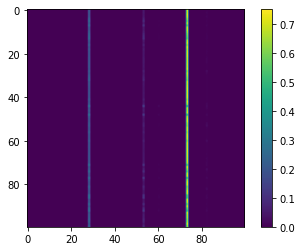

In [13]:
# 시각화

import matplotlib.pyplot as plt

score = attn_probs2[0][0]

plt.viridis()
plt.imshow(score)
plt.colorbar()

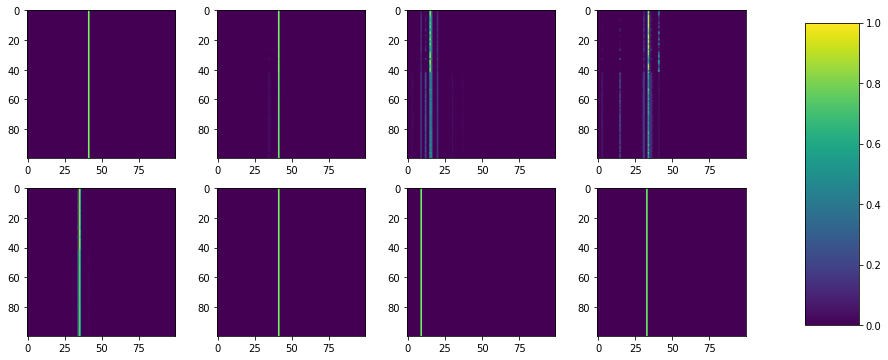

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))

for i in range(8):
    score = attn_probs2[4][i]
    plt.subplot(2,4,i+1)
    plt.viridis()
    im = plt.imshow(score)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

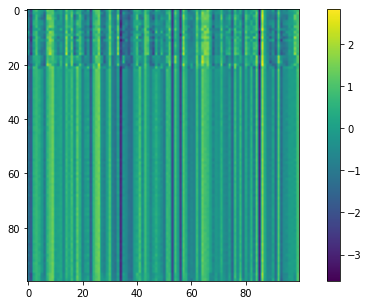

In [19]:
# 시각화

import matplotlib.pyplot as plt

outputs_score = attn_outputs2[10]

plt.figure(figsize=(10, 5))
plt.viridis()
plt.imshow(outputs_score)
plt.colorbar()
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default lea

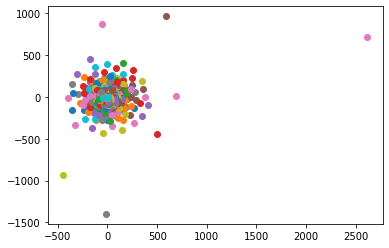

In [10]:
# t-sne
from sklearn.manifold import TSNE

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne_model = TSNE(n_components=n_components)

for j in range(emb_q2.shape[0]):
    tsne_result = tsne_model.fit_transform(emb_q2[j])
    for i in tsne_result:
        plt.scatter(i[0], i[1])

plt.show()